In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pydot
import os
from IPython.display import SVG, display
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    InverseDynamicsController,
    LeafSystem,
    MeshcatVisualizer,
    MultibodyPlant,
    Parser,
    Simulator,
    StartMeshcat,
    RotationMatrix,
    StateInterpolatorWithDiscreteDerivative,
    ConstantVectorSource,
    DiagramBuilder,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    MultibodyPlant,
    Parser,
    PiecewisePolynomial,
    PiecewiseQuaternionSlerp,
    RigidTransform,
    RollPitchYaw,
    RotationMatrix,
    Simulator,
    Solve,
    StartMeshcat,
    TrajectorySource,
)
from manipulation.station import MakeHardwareStation, load_scenario
from manipulation.scenarios import AddMultibodyTriad, MakeManipulationStation
from manipulation.meshcat_utils import AddMeshcatTriad
from pydrake.multibody import inverse_kinematics
import copy

In [3]:
import model_builder
import AllegroWrapper

In [4]:
meshcat, station, simulator, context = model_builder.old_scenario()
allegro = AllegroWrapper.AllegroHand(station, context)
x0 = allegro.get_state()

INFO:drake:Meshcat listening for connections at http://localhost:7001


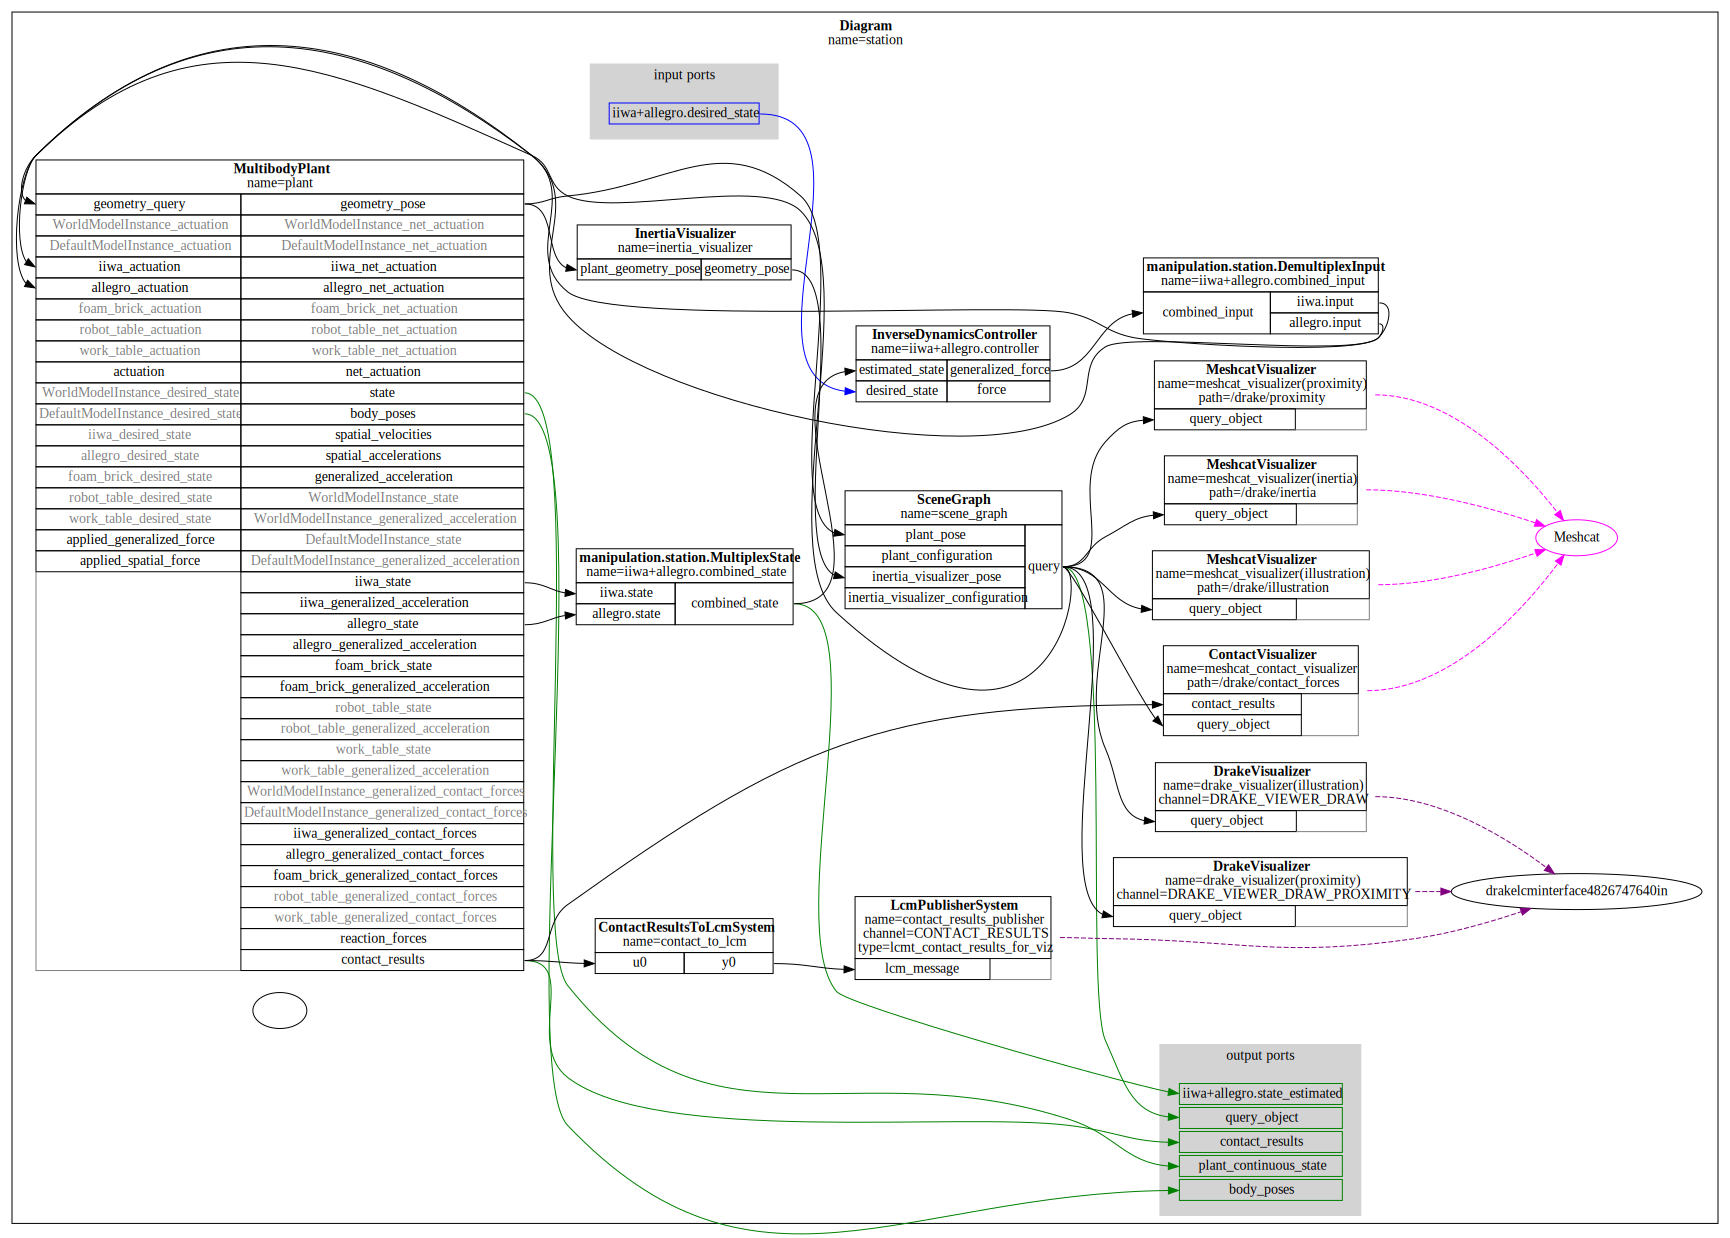

In [5]:
display(
    SVG(
        pydot.graph_from_dot_data(station.GetGraphvizString(max_depth=1))[
            0
        ].create_svg()
    )
)

In [6]:
plant = station.GetSubsystemByName("plant")

In [7]:
# Get initial pose of the gripper by using default context of manip station.
frame = "hand_root"
gripper = plant.GetBodyByName(frame)
plant_context = plant.GetMyContextFromRoot(context)
X_robot_W = plant.EvalBodyPoseInWorld(plant_context, gripper)

In [8]:
X_robot_W

RigidTransform(
  R=RotationMatrix([
    [-0.016666395910692303, 0.008332634516930441, 0.9998263841534472],
    [0.003378913288040095, 0.999960032797533, -0.008277424270255209],
    [-0.9998553966411047, 0.0032403718251401183, -0.01669388505096617],
  ]),
  p=[0.5689393697173113, -0.004596554601891682, 0.7279501811046996],
)

In [9]:
def reset_arm():
    station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, x0)
    simulator.AdvanceTo(context.get_time() + 1)

In [10]:
reset_arm()

In [11]:
final_rotation = X_robot_W.rotation()
initial_position = X_robot_W.translation()
final_position = [0.3, -0.05, -0.3]
# linearly interpolate between initial and final position

num_knot_points = 10
t_list = np.arange(num_knot_points)
positions = np.zeros((num_knot_points, 3))
for i in range(3):
    positions[:, i] = np.linspace(
        initial_position[i], final_position[i], num_knot_points
    )
p_list = []
for p in positions:
    p_list.append(RigidTransform(final_rotation, p))

In [12]:
def create_q_knots(pose_lst):
    """Convert end-effector pose list to joint position list using series of
    InverseKinematics problems. Note that q is 9-dimensional because the last 2 dimensions
    contain gripper joints, but these should not matter to the constraints.
    @param: pose_lst (python list): post_lst[i] contains keyframe X_WG at index i.
    @return: q_knots (python_list): q_knots[i] contains IK solution that will give f(q_knots[i]) \approx pose_lst[i].
    """
    q_knots = []
    plant = station.GetSubsystemByName("plant")
    world_frame = plant.world_frame()
    gripper_frame = plant.GetFrameByName(frame)
    iiwa_initial = np.array([0.0, 0.1, 0.0, -1.5, 0.0, 0.0, 0.0])
    gripper_initial = np.ones((23))
    q_nominal = np.hstack((iiwa_initial, gripper_initial))
    # q_nominal = iiwa_initial
    print(q_nominal.shape)

    def AddOrientationConstraint(ik, R_WG, bounds):
        """Add orientation constraint to the ik problem. Implements an inequality
        constraint where the axis-angle difference between f_R(q) and R_WG must be
        within bounds. Can be translated to:
        ik.prog().AddBoundingBoxConstraint(angle_diff(f_R(q), R_WG), -bounds, bounds)
        """
        ik.AddOrientationConstraint(
            frameAbar=world_frame,
            R_AbarA=R_WG,
            frameBbar=gripper_frame,
            R_BbarB=RotationMatrix(),
            theta_bound=bounds,
        )

    def AddPositionConstraint(ik, p_WG_lower, p_WG_upper):
        """Add position constraint to the ik problem. Implements an inequality
        constraint where f_p(q) must lie between p_WG_lower and p_WG_upper. Can be
        translated to
        ik.prog().AddBoundingBoxConstraint(f_p(q), p_WG_lower, p_WG_upper)
        """
        ik.AddPositionConstraint(
            frameA=world_frame,
            frameB=gripper_frame,
            p_BQ=np.zeros(3),
            p_AQ_lower=p_WG_lower,
            p_AQ_upper=p_WG_upper,
        )

    for i in range(len(pose_lst)):
        ik = inverse_kinematics.InverseKinematics(plant)
        # q_variables = ik.q()  # Get variables for MathematicalProgram
        q_variables = ik.q()  # Get variables for MathematicalProgram
        prog = ik.prog()  # Get MathematicalProgram

        pose = pose_lst[i]
        AddPositionConstraint(
                    ik,
                    pose.translation() + 0.01,
                    pose.translation() + 0.01,
        )

        # AddOrientationConstraint(
        #     ik,
        #     pose.rotation(),
        #     0.02,
        # )
        
        prog.AddQuadraticErrorCost(np.identity(len(q_variables)), q_nominal, q_variables)
        if i == 0:
            prog.SetInitialGuess(q_variables, q_nominal)
        else:
            prog.SetInitialGuess(q_variables, q_knots[i-1])

        result = Solve(prog)

        assert result.is_success()
        q_knots.append(result.GetSolution(q_variables))

    return q_knots

In [13]:
# q_knots = np.array(create_q_knots(pose_lst))
# q_traj = PiecewisePolynomial.CubicShapePreserving(t_lst, q_knots[:, 0:7].T)
q_knots = np.array(create_q_knots(p_list))
q_traj = PiecewisePolynomial.CubicShapePreserving(t_list, q_knots.T)

(30,)


In [14]:
def move_hand(station, context, end_point):
    current_state = station.GetInputPort("iiwa+allegro.desired_state").Eval(context)
    current_state[:end_point.shape[0]] = end_point
    station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, current_state)

In [15]:
contact = station.GetOutputPort("contact_results").Eval(context)
init_num_contacts = contact.num_point_pair_contacts()
contact_pre_move = []
for i in range(init_num_contacts):
    contact_pre_move.append(contact.point_pair_contact_info(i).contact_point())
print(contact_pre_move)

[array([ 6.37500000e-01,  2.50000000e-02, -1.01785224e-05]), array([ 6.37500000e-01, -2.50000000e-02, -1.01785224e-05]), array([ 5.62500000e-01,  2.50000000e-02, -1.01785224e-05]), array([ 5.62500000e-01, -2.50000000e-02, -1.01785224e-05])]


In [16]:
reset_arm()

In [17]:
def get_contacts(station, context):
    contacts = []
    contact = station.GetOutputPort("contact_results").Eval(context)
    num_contacts = contact.num_point_pair_contacts()
    for i in range(num_contacts):
        contacts.append(contact.point_pair_contact_info(i).contact_point())
    return contacts

In [18]:
all_q = q_knots[:, :7]
for each_q in q_knots:
    move_hand(station, context, each_q)
    simulator.AdvanceTo(simulator.get_context().get_time() + 0.05)
    contact = station.GetOutputPort("contact_results").Eval(context)
    num_contacts = contact.num_point_pair_contacts()
    if num_contacts != init_num_contacts:
        print("contact changed")
        for i in range(num_contacts):
            print(contact.point_pair_contact_info(i).contact_point())        

contact changed
[ 0.48131639  0.07131708 -0.00218903]
[ 0.48018411  0.0719955  -0.00216748]
[ 6.37500002e-01  2.50000014e-02 -7.79499185e-06]
[ 6.37500003e-01 -2.49999978e-02 -1.23335848e-05]
[ 5.62500004e-01  2.50000032e-02 -1.78317838e-05]
[ 5.62500006e-01 -2.49999960e-02 -2.23703767e-05]


In [19]:
contact = station.GetOutputPort("contact_results").Eval(context)
num_contacts = contact.num_point_pair_contacts()
contact_post_move = []
for i in range(num_contacts):
    # if contact.point_pair_contact_info(i).contact_point() not in contact_pre_move:
    contact_post_move.append(contact.point_pair_contact_info(i).contact_point())
contact_post_move

[array([ 0.48131639,  0.07131708, -0.00218903]),
 array([ 0.48018411,  0.0719955 , -0.00216748]),
 array([ 6.37500002e-01,  2.50000014e-02, -7.79499185e-06]),
 array([ 6.37500003e-01, -2.49999978e-02, -1.23335848e-05]),
 array([ 5.62500004e-01,  2.50000032e-02, -1.78317838e-05]),
 array([ 5.62500006e-01, -2.49999960e-02, -2.23703767e-05])]

In [20]:
x0[8]= 0

In [21]:
reset_arm()

In [23]:
reset_arm()
state = x0.copy()
state[1] = 1.3
state[5] = -1
allegro.set_state(state, context)
simulator.AdvanceTo(context.get_time() + 1)

In [37]:
contact = station.GetOutputPort("contact_results").Eval(context)
hydrocontact_info = contact.hydroelastic_contact_info(0)
csf = hydrocontact_info.contact_surface()
csf.

<HydroelasticContactRepresentation.kPolygon: 1>

In [19]:
get_contacts(station, context)

[array([ 8.43074910e-01,  6.69689029e-02, -1.78347145e-07])]

In [120]:
station.GetInputPort("iiwa+allegro.position_measured").FixValue(context, q_knots[0])

RuntimeError: System station does not have an input port named iiwa+allegro.position_measured (valid port names: iiwa+allegro.desired_state)

In [ ]:
contact = station.GetOutputPort("contact_results").Eval(context)
contact.point_pair_contact_info(2).contact_force

AttributeError: 'pydrake.multibody.plant.PointPairContactInfo' object has no attribute 'contact_forces'

In [ ]:
time = 0.2

In [ ]:
station.GetInputPort("iiwa+allegro.desired_state").Eval(context)[:7]

array([ 0. ,  0.1,  0. , -1.5,  0. ,  0. ,  0. ])

In [ ]:
def open_hand(station, context):
    current_state = station.GetInputPort("iiwa+allegro.desired_state").Eval(context)
    iiwa_idx = 7
    current_state[8] = 4
    station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, current_state)

In [ ]:
def close_hand(station, context):
    current_state = station.GetInputPort("iiwa+allegro.desired_state").Eval(context)
    iiwa_idx = 7
    current_state[8] = 0
    station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, current_state)

In [ ]:
allegro_map = {
    "index_revolute": 7,
    "index_0": 8,
    "index_1": 9,
    "index_2": 10,
    "thumb_": 11,
    "thumb_1": 12, 
    "thumb_revolute_z": 11,
    "thumb_revolute_y": 12, # avoid
    "thumb_joint_1": 13,
    "thumb_joint_2": 14,
    "middle_revolute": 15,
    "middle_0": 16,
    "middle_1": 17,
    "middle_2": 18,
    "pinky_revolute": 19,
    "pinky_0": 20,
    "pinky_1": 21,
    "pinky_2": 22
}

In [ ]:
def reset_hand(station, context):
    current_state = station.GetInputPort("iiwa+allegro.desired_state").Eval(context)
    current_state[7:] = 0
    station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, current_state)

In [ ]:
def move_finger(station, context, index, amount):
    current_state = station.GetInputPort("iiwa+allegro.desired_state").Eval(context)
    current_state[index] = amount
    station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, current_state)

index = 22
amount = 2

reset_hand(station, context)
simulator.AdvanceTo(time) 
time += 1

move_finger(station, context, index, amount)
simulator.AdvanceTo(time)
time += 1

In [ ]:
open_hand(station, context)
simulator.AdvanceTo(time)
time += 1

In [ ]:
close_hand(station, context)
simulator.AdvanceTo(time)
time += 1

In [ ]:
plant.get_contact_model()

<ContactModel.kHydroelasticWithFallback: 2>

In [ ]:
contact = station.GetOutputPort("contact_results").Eval(context)
num_contacts = contact.num_point_pair_contacts()
print(num_contacts)
a = contact.point_pair_contact_info(1)
a.contact_point()

8


array([ 7.20192680e-01,  1.15709952e-01, -5.80416268e-05])

[0.76671662 0.15635648 0.029096  ]
[ 7.20192680e-01  1.15709952e-01 -5.80416268e-05]
[0.80215838 0.10720572 0.02441489]
[ 7.95898018e-01  9.72281132e-02 -2.13457851e-04]
[ 6.37500001e-01  2.50000016e-02 -7.61718707e-06]
[ 6.37500002e-01 -2.49999973e-02 -1.28237572e-05]
[ 5.62500002e-01  2.50000026e-02 -1.28237666e-05]
[ 5.62500003e-01 -2.49999963e-02 -1.80303367e-05]


In [ ]:
end_effector_frame = station.